# PFE - evaluation
*version 03/03/2024*

In [1]:
import os
import s3fs

import pickle
import numpy as np

import matplotlib.pyplot as plt

device = 'cpu'

In [2]:
# connection to database
S3_ENDPOINT_URL = "https://" + os.environ["AWS_S3_ENDPOINT"]
fs = s3fs.S3FileSystem(client_kwargs={'endpoint_url': S3_ENDPOINT_URL})

BUCKET_X_TRUE_TEST = "clemphg/x_true_test"
BUCKET_X_FBP = "clemphg/x_fbp"
BUCKET_X_CP_RECON = "clemphg/CP_recon_torch100"

BUCKET_X_CP_RECON_BETA30 = "clemphg/CP_recon_torch100_beta30"

x_true_test_filenames = fs.ls(BUCKET_X_TRUE_TEST)[1:]
x_fbp_filenames = fs.ls(BUCKET_X_FBP)[1:]
cp_recon_filenames = fs.ls(BUCKET_X_CP_RECON)[1:]

cp_recon_beta30_filenames = fs.ls(BUCKET_X_CP_RECON_BETA30)[1:]

In [3]:
# load data
def import_data(file_paths):
    data = []
    for file_path in file_paths:
        with fs.open(file_path, mode="rb") as file_in:
            data.append(np.load(file_in, encoding="bytes"))
    return data

In [24]:
ground_truth = import_data(x_true_test_filenames)
x_fbp = import_data(x_fbp_filenames)
cp_recon = import_data(cp_recon_filenames)

cp_recon_beta30 = import_data(cp_recon_beta30_filenames)

# Compute mean SNR and computation time

In [25]:
def psnr(original, reconstructed):

    # normalizing to have pixels between 0 and 1 to compute the peak signal to noise ratio
    noriginal = (original - np.min(original)) / (np.max(original) - np.min(original))
    nreconstructed = (reconstructed - np.min(reconstructed)) / (np.max(reconstructed) - np.min(reconstructed))

    # compute Mean Squared Error (MSE)
    mse = np.mean((noriginal - nreconstructed) ** 2)

    # compute PSNR in decibels
    if mse == 0:
        return float('inf')  # PSNR is infinite if the images are identical
    else:
        psnr_value = 10 * np.log10((1 ** 2) / mse) # 1 being the max pixel value / range of pixel values
        return psnr_value

In [28]:
psnr_fbp = [psnr(gt, fbp) for gt, fbp in zip(ground_truth, x_fbp)]
psnr_cp = [psnr(gt, cp) for gt, cp in zip(ground_truth, cp_recon)]

psnr_cp_beta30 = [psnr(gt, cp) for gt, cp in zip(ground_truth, cp_recon_beta30)]
#psnr_unetl1 = [psnr(gt, unetl1) for gt, unetl1 in zip(ground_truth, unetl1_imgs)]
#psnr_unetl2 = [psnr(gt, unetl2) for gt, unetl2 in zip(ground_truth, unetl2_imgs)]
#psnr_metainv = [psnr(gt, metainv) for gt, metainv in zip(ground_truth, metainvnet_imgs)]

In [29]:
print("Mean SNR for FBP images                  :",np.mean(psnr_fbp))
print("Mean SNR for CP images                   :",np.mean(psnr_cp))
print("Mean SNR for CP images (beta = 30)       :",np.mean(psnr_cp_beta30))
#print("Mean SNR for FBPConvNet (L1 loss) images :",np.mean(psnr_unetl1))
#print("Mean SNR for FBPConvNet (L2 loss) images :",np.mean(psnr_unetl2))
#print("Mean SNR for MetaInv-Net images          :",np.mean(psnr_metainv))

Mean SNR for FBP images                  : 13.126498992662702
Mean SNR for CP images                   : 32.77239720758918
Mean SNR for CP images (beta = 30)       : 33.045679312493846


In [30]:
print("Std SNR for FBP images                  :",np.std(psnr_fbp))
print("Std SNR for CP images                   :",np.std(psnr_cp))
print("Std SNR for CP images (beta = 30)       :",np.std(psnr_cp_beta30))
#print("Std SNR for FBPConvNet (L1 loss) images :",np.std(psnr_unetl1))
#print("Std SNR for FBPConvNet (L2 loss) images :",np.std(psnr_unetl2))
#print("Std SNR for MetaInv-Net images          :",np.std(psnr_metainv))

Std SNR for FBP images                  : 2.272862435040202
Std SNR for CP images                   : 3.4597876941335155
Std SNR for CP images (beta = 30)       : 3.110083636035878


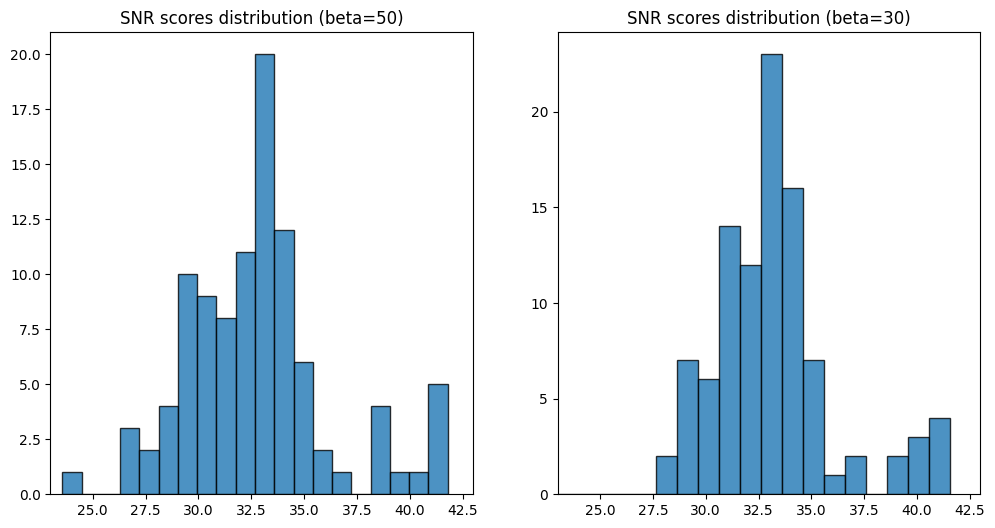

In [33]:
# plot distribution of SNR

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].hist(psnr_cp, bins = 20, edgecolor='black', alpha=0.8)
axes[0].set_title(f"SNR scores distribution (beta=50)")
axes[0].set_xlim([23, 43])

axes[1].hist(psnr_cp_beta30, bins = 20, edgecolor='black', alpha=0.8)
axes[1].set_title(f"SNR scores distribution (beta=30)")
axes[1].set_xlim([23, 43])

plt.show()

## Compute SSIM (structural similarity)

In [34]:
import torch
import torch.nn.functional as F

In [35]:
from pytorch_msssim import SSIM, MS_SSIM


def ssim(pred, y):

    pred = torch.from_numpy(np.array([[pred]])).to(dtype=torch.float32).to(device)
    y = torch.from_numpy(np.array([[y]])).to(dtype=torch.float32).to(device)
    
    data_range = torch.max(torch.tensor([torch.max(pred) - torch.min(pred), torch.max(y) - torch.min(y)]))
    ssim = SSIM(win_size=11, win_sigma=1.5, data_range=data_range, size_average=True, channel=1)
    return ssim(pred, y).item()

In [36]:
ssim_fbp = [ssim(gt, fbp) for gt, fbp in zip(ground_truth, x_fbp)]
ssim_cp = [ssim(gt, cp) for gt, cp in zip(ground_truth, cp_recon)]
ssim_cp_beta30 = [ssim(gt, cp) for gt, cp in zip(ground_truth, cp_recon_beta30)]

#ssim_unetl1 = [ssim(gt, unetl1) for gt, unetl1 in zip(ground_truth, unetl1_imgs)]
#ssim_unetl2 = [ssim(gt, unetl2) for gt, unetl2 in zip(ground_truth, unetl2_imgs)]
#ssim_metainv = [ssim(gt, metainv) for gt, metainv in zip(ground_truth, metainvnet_imgs)]

In [37]:
print("Mean SSIM for FBP images                  :",np.mean(ssim_fbp))
print("Mean SSIM for CP images                   :",np.mean(ssim_cp))
print("Mean SSIM for CP images (beta = 30)       :",np.mean(ssim_cp_beta30))

#print("Mean SSIM for FBPConvNet (L1 loss) images :",np.mean(ssim_unetl1))
#print("Mean SSIM for FBPConvNet (L2 loss) images :",np.mean(ssim_unetl2))
#print("Mean SSIM for MetaInv-Net images          :",np.mean(ssim_metainv))

Mean SSIM for FBP images                  : 0.3395135004818439
Mean SSIM for CP images                   : 0.9121077823638916
Mean SSIM for CP images (beta = 30)       : 0.9058263731002808


In [38]:
print("Std SSIM for CP images                   :",np.std(ssim_fbp))
print("Std SSIM for CP images                   :",np.std(ssim_cp))
print("Std SSIM for CP images (beta = 30)       :",np.std(ssim_cp_beta30))

#print("Std SSIM for FBPConvNet (L1 loss) images :",np.std(ssim_unetl1))
#print("Std SSIM for FBPConvNet (L2 loss) images :",np.std(ssim_unetl2))
#print("Std SSIM for MetaInv-Net images          :",np.std(ssim_metainv))

Std SSIM for CP images                   : 0.04371910009264495
Std SSIM for CP images                   : 0.03447357381142316
Std SSIM for CP images (beta = 30)       : 0.03537047198468405


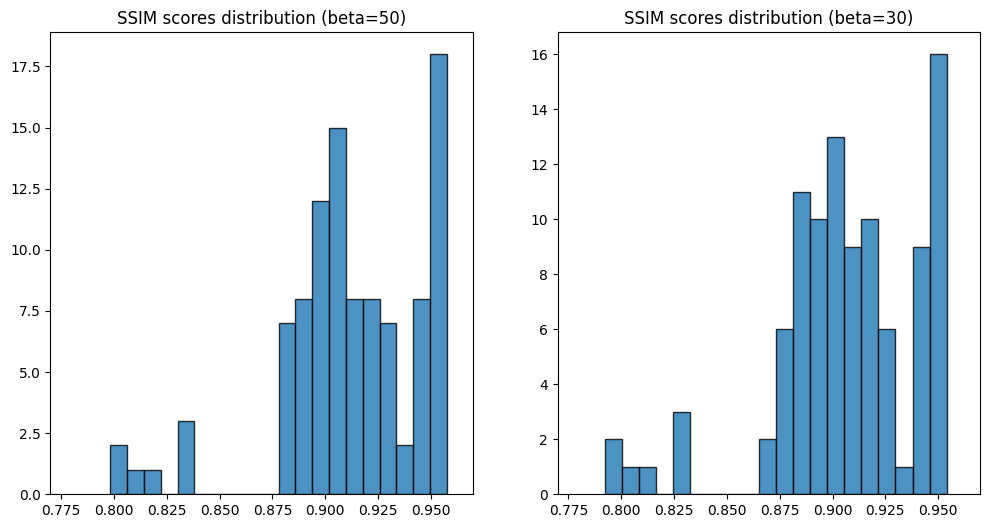

In [41]:
# plot distribution of SSIM

fig, axes = plt.subplots(1, 2, figsize=(12, 6))

axes[0].hist(ssim_cp, bins = 20, edgecolor='black', alpha=0.8)
axes[0].set_title(f"SSIM scores distribution (beta=50)")
axes[0].set_xlim([0.77, 0.97])

axes[1].hist(ssim_cp_beta30, bins = 20, edgecolor='black', alpha=0.8)
axes[1].set_title(f"SSIM scores distribution (beta=30)")
axes[1].set_xlim([0.77, 0.97])

plt.show()

# Plot sample image

In [42]:
def plot_images(index):
    img_name = cp_recon_filenames[index][26:]
    
    # Display the reconstructed image
    fig, axes = plt.subplots(1, 3, figsize=(12, 6))

    axes[0].imshow(ground_truth[index], 'gray')
    axes[0].axis('off')
    axes[0].set_title(f"Original image\n{img_name}")

    axes[1].imshow(cp_recon[index], 'gray')
    axes[1].axis('off')
    axes[1].set_title(f"CP (beta=50)\nSNR {round(psnr_cp[index],2)}\nSSIM {round(ssim_cp[index],2)}")

    axes[2].imshow(cp_recon_beta30[index], 'gray')
    axes[2].axis('off')
    axes[2].set_title(f"CP (beta=30)\nSNR {round(psnr_cp_beta30[index],2)}\nSSIM {round(ssim_cp_beta30[index],2)}")

    plt.show()

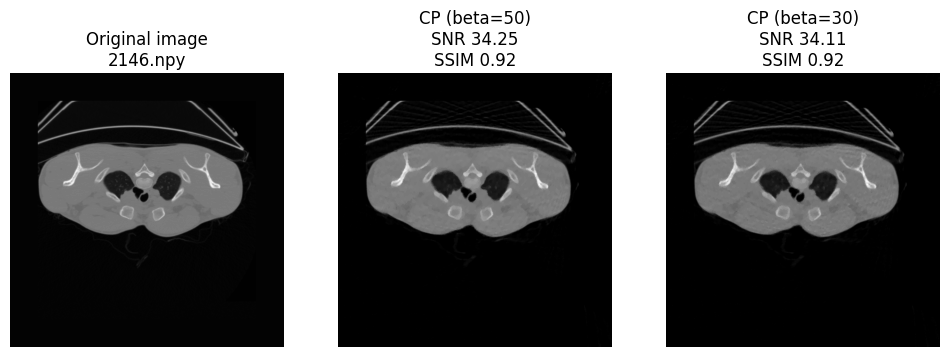

In [43]:
plot_images(25)

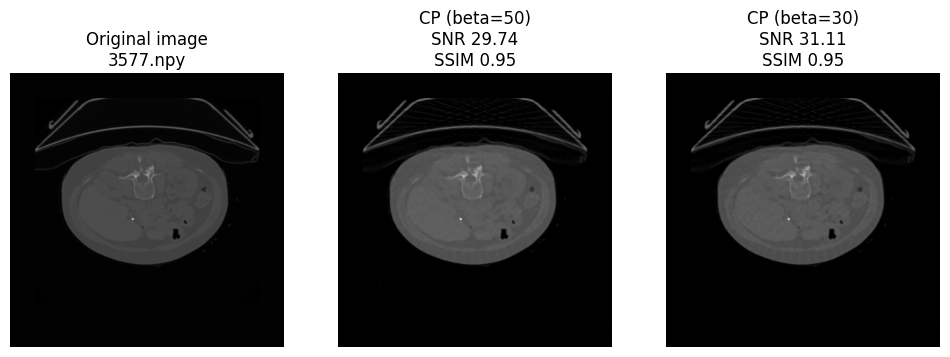

In [44]:
plot_images(55)

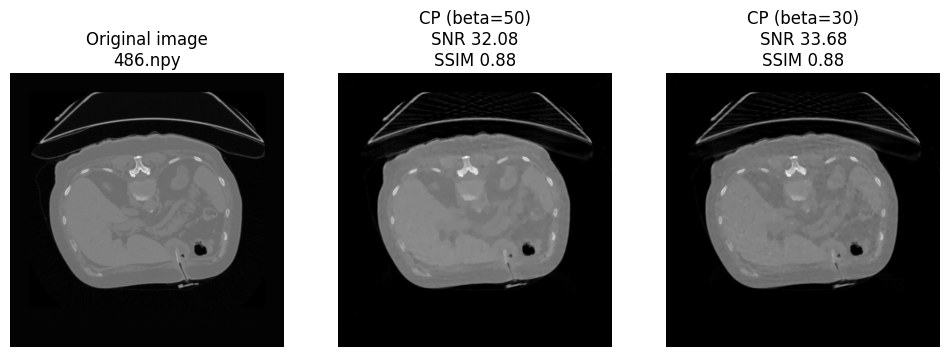

In [46]:
plot_images(75)

In [59]:
def plot_images_betas(index, hmargin=300, vmargin=300, lmargin=100, tmargin=100):
    img_name = cp_recon_filenames[index][26:]

    h, w = ground_truth[index].shape

    rmargin, bmargin = hmargin-lmargin, vmargin-tmargin
    
    # Display the reconstructed image
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    plt.subplots_adjust(hspace=0.01, wspace=0.01)  # Adjust the value as needed

    # First row with original images
    axes[0,0].imshow(ground_truth[index], 'gray')
    axes[0,0].axis('off')
    axes[0,0].set_title(f"Ground truth\n{img_name}")

    axes[0,1].imshow(cp_recon[index], 'gray')
    axes[0,1].axis('off')
    axes[0,1].set_title(f"CP (beta=50)\nSNR {round(psnr_cp[index],2)} || SSIM {round(ssim_cp[index],3)}")

    axes[0,2].imshow(cp_recon_beta30[index], 'gray')
    axes[0,2].axis('off')
    axes[0,2].set_title(f"CP (beta=30)\nSNR {round(psnr_cp_beta30[index],2)} || SSIM {round(ssim_cp_beta30[index],3)}")

    # Second row with zoomed-in images

    axes[1,0].imshow(ground_truth[index][tmargin:h-bmargin, lmargin:w-rmargin], 'gray')
    axes[1,0].margins(0.5)
    axes[1,0].axis('off')

    axes[1,1].imshow(cp_recon[index][tmargin:h-bmargin, lmargin:w-rmargin], 'gray')
    axes[1,1].axis('off')

    axes[1,2].imshow(cp_recon_beta30[index][tmargin:h-bmargin, lmargin:w-rmargin], 'gray')
    axes[1,2].axis('off')

    plt.show()

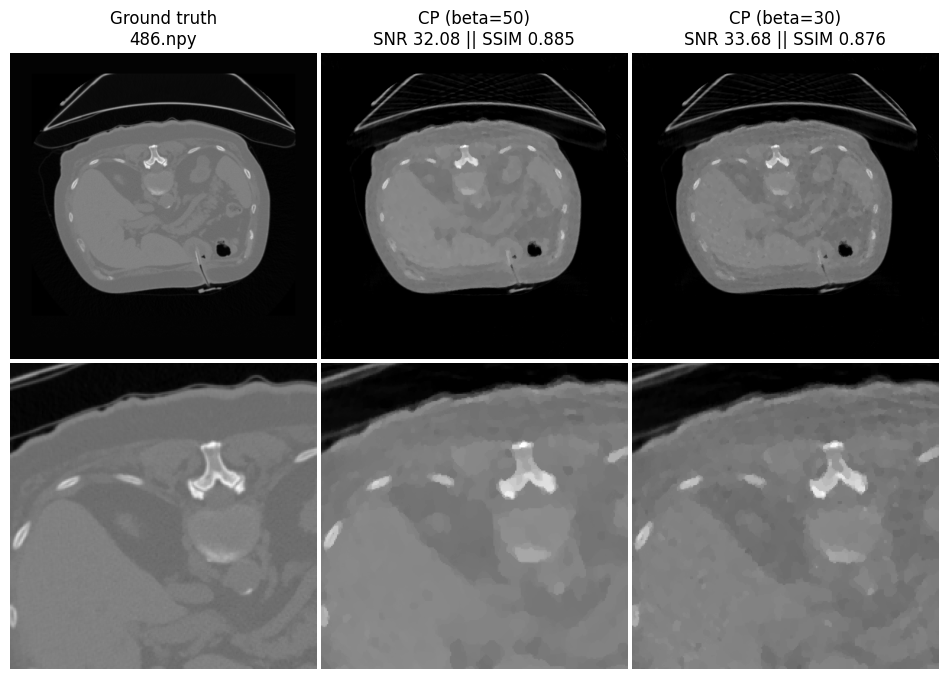

In [60]:
plot_images_betas(75)

## Plots with zoom

In [92]:
def plot_images_zoom(index, hmargin=300, vmargin=300, lmargin=100, tmargin=100):
    img_name = cp_recon_filenames[index][26:]

    h, w = ground_truth[index].shape

    rmargin, bmargin = hmargin-lmargin, vmargin-tmargin
    
    # Display the reconstructed image
    fig, axes = plt.subplots(2, 3, figsize=(12, 8))
    plt.subplots_adjust(hspace=0.01, wspace=0.01)  # Adjust the value as needed

    # First row with original images
    axes[0,0].imshow(ground_truth[index], 'gray')
    axes[0,0].axis('off')
    axes[0,0].set_title(f"Ground truth\n{img_name}")

    axes[0,1].imshow(x_fbp[index], 'gray')
    axes[0,1].axis('off')
    axes[0,1].set_title(f"FBP\nSNR {round(psnr_fbp[index],2)} || SSIM {round(ssim_fbp[index],3)}")

    axes[0,2].imshow(cp_recon[index], 'gray')
    axes[0,2].axis('off')
    axes[0,2].set_title(f"CP\nSNR {round(psnr_cp[index],2)} || SSIM {round(ssim_cp[index],3)}")

    # Second row with zoomed-in images

    axes[1,0].imshow(ground_truth[index][tmargin:h-bmargin, lmargin:w-rmargin], 'gray')
    axes[1,0].margins(0.5)
    axes[1,0].axis('off')

    axes[1,1].imshow(x_fbp[index][tmargin:h-bmargin, lmargin:w-rmargin], 'gray')
    axes[1,1].axis('off')

    axes[1,2].imshow(cp_recon[index][tmargin:h-bmargin, lmargin:w-rmargin], 'gray')
    axes[1,2].axis('off')

    plt.savefig(img_name[:-4]+'.png', bbox_inches='tight', pad_inches=0)
    plt.show()

In [105]:
def comp_l2(index):
    gt = ground_truth[index]
    pred = cp_recon[index]
    pred2 = cp_recon_beta30[index]
    
    temp = sum(sum((gt-pred)**2))
    temp2 = sum(sum((gt-pred2)**2))
    return temp, temp2

print(comp_l2(25))
print(comp_l2(50))
print(comp_l2(75))

(0.09773944304235727, 0.10392147283107533)
(0.1303386483623683, 0.1415774987213183)
(0.11651312331309782, 0.12467435396266069)


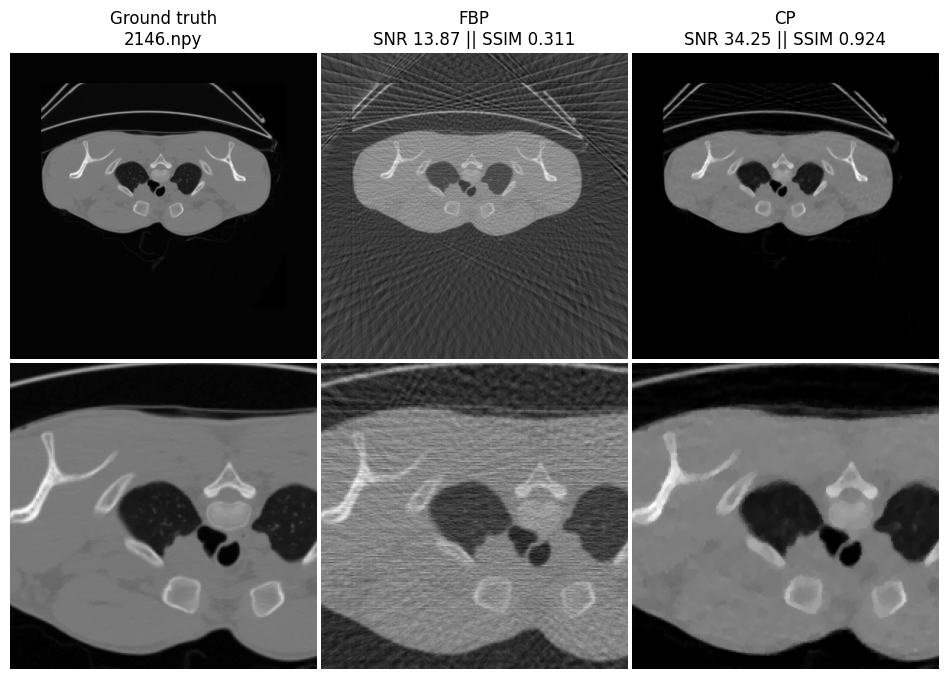

In [104]:
plot_images_zoom(25)

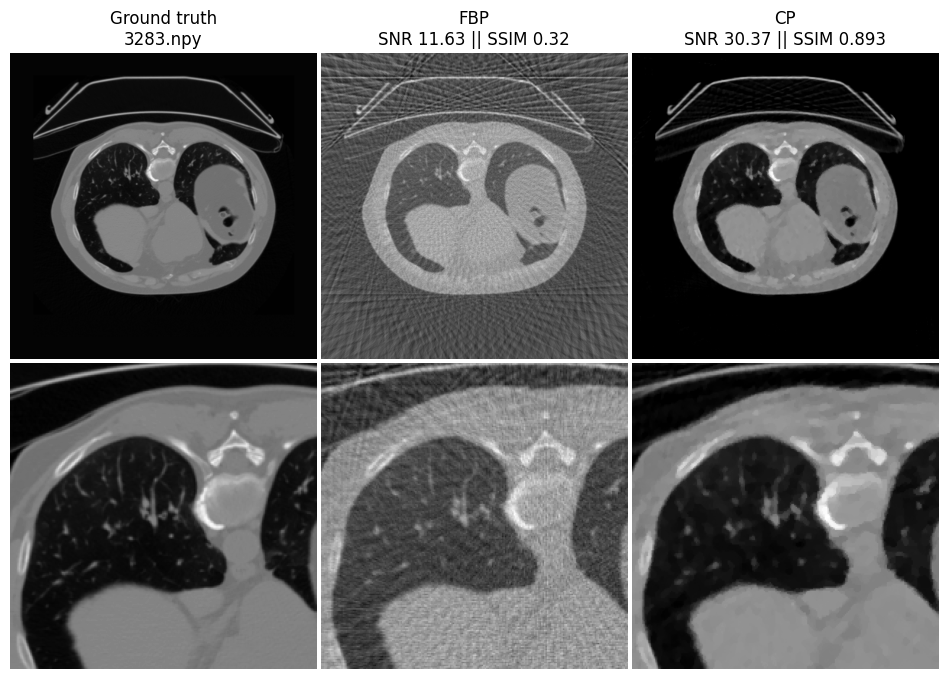

In [94]:
plot_images_zoom(50)

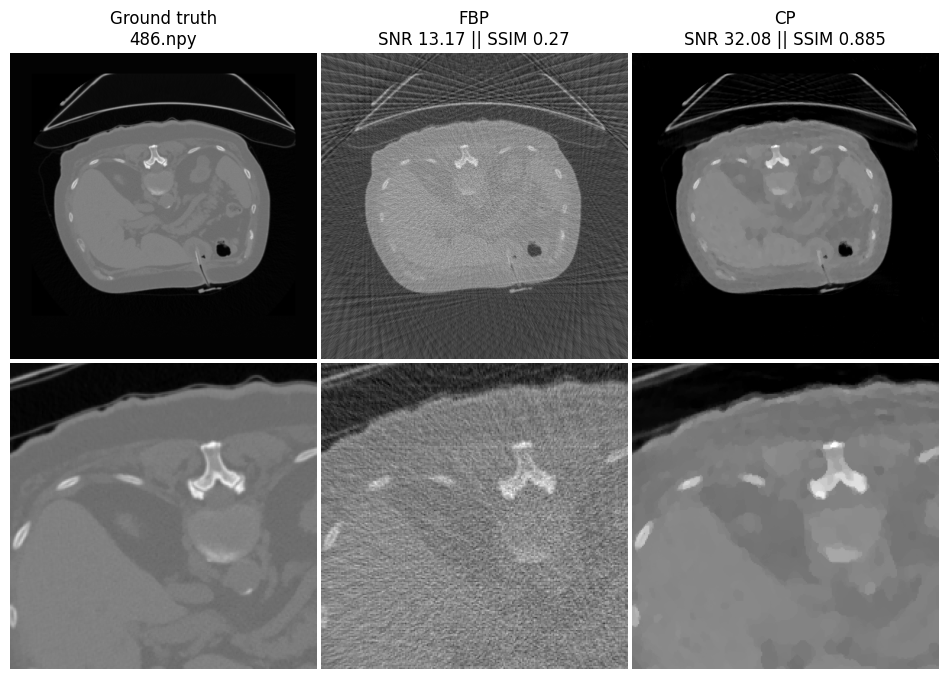

In [95]:
plot_images_zoom(75)